In [1]:
import GPy
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = np.load("DataSamples.npy").item()

In [41]:
x = np.array(data["actions"][:100])
y = np.array(data["reward"][:100])

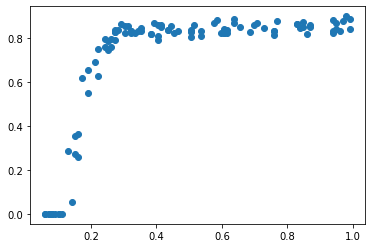

In [42]:
plt.plot(x, y, 'o')

In [43]:
kernel_vgp = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
vgp = GPy.models.GPRegression(x.reshape(-1,1), y.reshape(-1,1), kernel_vgp)
vgp.optimize(messages=False)
vgp.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -142.46377643828055
Optimization restart 2/10, f = -142.4637764372475
Optimization restart 3/10, f = -142.4637764383164
Optimization restart 4/10, f = -142.46377643825699
Optimization restart 5/10, f = -142.463776438135
Optimization restart 6/10, f = -142.4637764383515
Optimization restart 7/10, f = -142.46377643834916
Optimization restart 8/10, f = -142.4637764376229
Optimization restart 9/10, f = -142.463776435336
Optimization restart 10/10, f = -142.46377643815993


Text(0.5, 1.0, 'Objective Function')

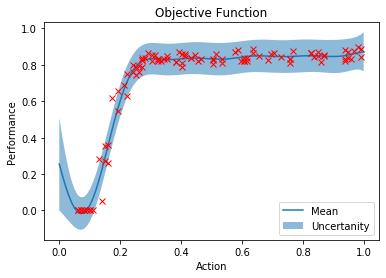

In [44]:
# Plot error bounds
x_test = np.linspace(0.0,1.0, 100)
m, v = vgp.predict(x_test.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))

plt.fill_between(x_test, up, dwn, alpha=0.5, label="Uncertanity")
plt.plot(x_test, m, label="Mean")
plt.plot(x, y,'x',color='red')
plt.legend()
plt.ylabel("Performance")
plt.xlabel("Action")
plt.title("Objective Function")

In [45]:
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = -142.46377643828055
Optimization restart 2/5, f = -142.46377643834668
Optimization restart 3/5, f = -142.4637764382112
Optimization restart 4/5, f = -142.46377643819272
Optimization restart 5/5, f = -142.4637764383473


In [46]:
m, v = gp1.predict(x.reshape(-1,1))
s = 20
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)

In [47]:
kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x.reshape(-1,1),z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 2)
m_n, v_n = gp2.predict(x.reshape(-1,1))

Optimization restart 1/2, f = 216.90470073258174
Optimization restart 2/2, f = 216.90470074023673


In [48]:
rbf = GPy.kern.RBF(input_dim=1)
noise = GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
k3 = rbf + noise
gp3 = GPy.models.GPRegression(x.reshape(-1,1), y.reshape(-1,1), k3)
k3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

In [51]:
k3.parts[0] = kernel1.parts[0]
gp3.optimize()
gp3.optimize_restarts(5)

Optimization restart 1/5, f = -270.14686020774457
Optimization restart 2/5, f = -260.8248707748505
Optimization restart 3/5, f = -265.6491560530641
Optimization restart 4/5, f = -261.0946617523283
Optimization restart 5/5, f = -260.60876316272436


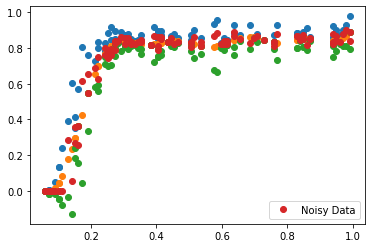

In [52]:
m, v = gp3.predict(x.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.plot(x, up, 'o')
plt.plot(x, m, 'o')
plt.plot(x, dwn, 'o')
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()

No handles with labels found to put in legend.


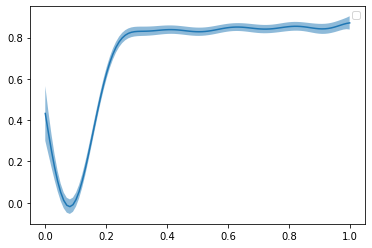

In [54]:
valve = np.linspace(0, 1.0, 100)
m_n, v_n = gp2.predict(valve.reshape(-1,1))
k3.parts[1].variance = np.exp(m_n).reshape(valve.shape[0])
m, v = gp3.predict(valve.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.fill_between(valve, up, dwn, alpha=0.5)
plt.plot(valve, m)
#plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()